In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# 코드 6-28 예나의 날씨 데이터셋 조사하기
import os

data_dir = "./deep-learning-with-python-notebooks-master/datasets"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
# 코드 6-29 데이터 파싱하기
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i, :] = values

In [4]:
# 코드 6-30 시계열 온도 그래프 그리기
import matplotlib.pyplot as plt

temp = float_data[:, 1] # 온도
plt.plot(range(len(temp)), temp)

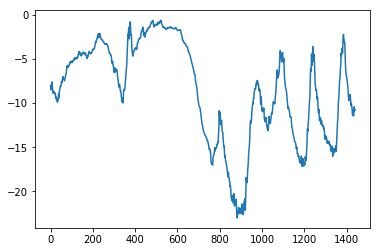

In [5]:
# 코드 6-31 처음 10일간 온도 그래프 그리기
plt.plot(range(1440), temp[:1440])

In [4]:
# 코드 6-32 데이터 정규화하기
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std  = float_data[:200000].std(axis = 0)
float_data /= std

In [5]:
# 코드 6-33 시계열 데이터와 타깃을 반환하는 제너레이터 함수
def generator(data, lookback, delay, min_index, max_index,
             shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback,
                                    max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [6]:
# 코드 6-34 훈련, 검증, 테스트 제너레이터 준비하기
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                     lookback= lookback,
                      delay = delay,
                     min_index=0,
                     max_index=200000,
                     shuffle = True,
                     step = step,
                     batch_size=batch_size)
val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   step=step,
                   batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step = step,
                    batch_size=batch_size)


In [7]:
val_steps = (300000 - 200001 - lookback) // batch_size # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수

test_steps = (len(float_data) - 300001 - lookback) // batch_size # 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수

In [10]:
# 코드 6-35 상식적인 기준 모델의 MAE 계산하기
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


In [11]:
# 코드 6-36 MAE를 섭씨 단위로 변환하기
celsius_mae = 0.29 * std[1]

In [12]:
celsius_mae

2.5672247338393395

In [13]:
# 코드 6-37 완전 연결 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dense(1))

In [14]:
model.compile(loss = "mae", optimizer=RMSprop())

In [15]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs = 20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 9s 18ms/step - loss: 1.0713 - val_loss: 0.5165
Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3641 - val_loss: 0.3526
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2863 - val_loss: 0.3047
Epoch 4/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2623 - val_loss: 0.3040
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2509 - val_loss: 0.3092
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2431 - val_loss: 0.3160
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2378 - val_loss: 0.3189
Epoch 8/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2310 - val_loss: 0.3185
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2247 - val_loss: 0.3326
Epoch 10/20
500

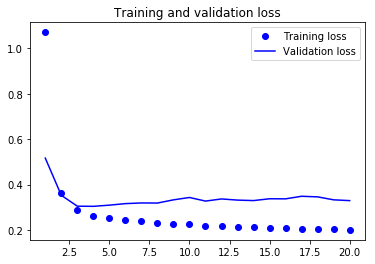

In [16]:
# 코드 6-38 결과 그래프 그리기
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
cell = layers.GRUCell(32, input_shape = (None, float_data.shape[-1]))
model.add(layers.RNN(cell))
model.add(layers.Dense(1))

In [18]:
model.compile(loss = "mae",
             optimizer = RMSprop())

In [19]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs = 20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2976 - val_loss: 0.2739
Epoch 2/20
500/500 [==============================] - 94s 189ms/step - loss: 0.2855 - val_loss: 0.2689
Epoch 3/20
500/500 [==============================] - 94s 189ms/step - loss: 0.2787 - val_loss: 0.2625
Epoch 4/20
500/500 [==============================] - 94s 189ms/step - loss: 0.2719 - val_loss: 0.2607
Epoch 5/20
500/500 [==============================] - 95s 189ms/step - loss: 0.2680 - val_loss: 0.2772
Epoch 6/20
500/500 [==============================] - 95s 189ms/step - loss: 0.2631 - val_loss: 0.2682
Epoch 7/20
500/500 [==============================] - 94s 189ms/step - loss: 0.2598 - val_loss: 0.2640
Epoch 8/20
500/500 [==============================] - 95s 189ms/step - loss: 0.2552 - val_loss: 0.2675
Epoch 9/20
500/500 [==============================] - 94s 189ms/step - loss: 0.2504 - val_loss: 0.2681
Epoch 10/20
500/500 [==============================] - 95s 189ms/step - l

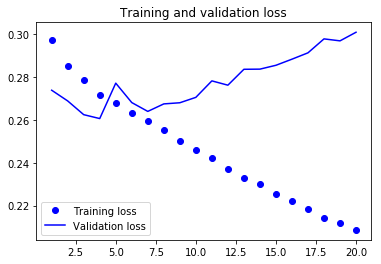

In [20]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [25]:
# 코드 6-40 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
cell = layers.GRUCell(32, dropout = 0.2, recurrent_dropout = 0.2, 
                     input_shape = (None, float_data.shape[-1]))
model.add(layers.RNN(cell, return_sequences=True))
model.add(layers.Dense(1))

In [26]:
model.compile(loss = "mae",
             optimizer = RMSprop())

In [ ]:
history = model.fit_generator(train_gen,
                             steps_per_epoch = 500,
                             epochs = 40,
                             validation_data =val_gen,
                             validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 160s 320ms/step - loss: 0.5015 - val_loss: 0.4708
Epoch 2/40
500/500 [==============================] - 160s 320ms/step - loss: 0.4692 - val_loss: 0.4788
Epoch 3/40
398/500 [======================>.......] - ETA: 27s - loss: 0.4474

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [43]:
#############################################################################################################
# 코드 5-41 드롭아웃으로 규제하고 스태킹한 GRU 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
cell = layers.GRU(32, dropout=0.1,
                     recurrent_dropout=0.5, return_sequences=True,
                 input_shape = (None, float_data.shape[-1]))
model.add(layers.RNN(cell))
cell = layers.GRUCell(64, activation="relu",
                     dropout = 0.1,
                     recurrent_dropout=0.5)
model.add(layers.RNN(cell))
model.add(layers.Dense(1))

ValueError: The RNN cell should have an attribute `state_size` (tuple of integers, one integer per RNN state).

In [23]:
model.compile(loss = "mae",
             optimizer = RMSprop())

In [ ]:
history = model.fit_generator(train_gen,
                             steps_per_epoch = 500,
                             epochs = 40, 
                             validation_data = val_gen,
                             validation_steps = val_steps)

In [24]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

NameError: name 'history' is not defined

In [29]:
# 코드 6-42  거꾸로 된 시퀀스를 사용한 LSTM을 훈련하고 평가하기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000 # 특성으로 사용할 단어의 수
maxlen = 500 # 사용할 텍스트의 길이(가장 빈번한 max_features개의 ㅏ단어만 사용합니다)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features) # 데이터 로드

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [30]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
cell = layers.LSTMCell(32)
model.add(layers.RNN(cell))
model.add(layers.Dense(1, activation = "sigmoid"))

In [31]:
model.compile(loss = "binary_crossentropy",
             optimizer= "rmsprop",
             metrics = ["acc"])

In [32]:
history = model.fit(x_train, y_train,
                   epochs = 10, 
                   batch_size=128,
                   validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 49s 314ms/step - loss: 0.4989 - acc: 0.7607 - val_loss: 0.3848 - val_acc: 0.8428
Epoch 2/10
157/157 [==============================] - 49s 314ms/step - loss: 0.3174 - acc: 0.8763 - val_loss: 0.3816 - val_acc: 0.8620
Epoch 3/10
157/157 [==============================] - 49s 315ms/step - loss: 0.2576 - acc: 0.9039 - val_loss: 0.3561 - val_acc: 0.8456
Epoch 4/10
157/157 [==============================] - 49s 314ms/step - loss: 0.2157 - acc: 0.9222 - val_loss: 0.3529 - val_acc: 0.8584
Epoch 5/10
 76/157 [=============>................] - ETA: 24s - loss: 0.2026 - acc: 0.9317

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [40]:
# 코드 6-23 양방향 LSTM을 훈련하고 평가하기
model = Sequential()
model.add(layers.Embedding(max_features, 32))
cell = layers.LSTM(32)
model.add(layers.Bidirectional(cell))
model.add(layers.Dense(1, activation = "sigmoid"))

In [35]:
model.compile(loss = "binary_crossentropy",
             optimizer = "rmsprop",
             metrics = ["acc"])

In [36]:
history = model.fit(x_train,y_train,
                   epochs = 10,
                   batch_size = 128,
                   validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 10s 66ms/step - loss: 0.5470 - acc: 0.7267 - val_loss: 0.5083 - val_acc: 0.7538
Epoch 2/10
157/157 [==============================] - 10s 62ms/step - loss: 0.3237 - acc: 0.8745 - val_loss: 0.2964 - val_acc: 0.8830
Epoch 3/10
157/157 [==============================] - 10s 63ms/step - loss: 0.2641 - acc: 0.9021 - val_loss: 0.3105 - val_acc: 0.8850
Epoch 4/10
157/157 [==============================] - 10s 62ms/step - loss: 0.2224 - acc: 0.9196 - val_loss: 0.3181 - val_acc: 0.8696
Epoch 5/10
157/157 [==============================] - 9s 60ms/step - loss: 0.1991 - acc: 0.9299 - val_loss: 0.3237 - val_acc: 0.8824
Epoch 6/10
157/157 [==============================] - 10s 64ms/step - loss: 0.1754 - acc: 0.9381 - val_loss: 0.3638 - val_acc: 0.8660
Epoch 7/10
 17/157 [==>...........................] - ETA: 7s - loss: 0.1416 - acc: 0.9490

KeyboardInterrupt: 

In [15]:
#########################################################################
# 코드 6-44 양방향 GRU 훈련하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
cell = layers.GRU(32, input_shape=(None, float_data.shape[-1]))
model.add(layers.Bidirectional(cell))
model.add(layers.Dense(1))

In [16]:
model.compile(loss = "mae",
             optimizer=RMSprop())

In [17]:
history = model.fit_generator(train_gen,
                             steps_per_epoch = 500,
                             epochs = 40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
500/500 [==============================] - 17s 33ms/step - loss: 0.2971 - val_loss: 0.2680
Epoch 2/40
500/500 [==============================] - 16s 32ms/step - loss: 0.2767 - val_loss: 0.2692
Epoch 3/40
500/500 [==============================] - 16s 33ms/step - loss: 0.2689 - val_loss: 0.2788
Epoch 4/40
500/500 [==============================] - 17s 35ms/step - loss: 0.2622 - val_loss: 0.2625
Epoch 5/40
500/500 [==============================] - 17s 35ms/step - loss: 0.2594 - val_loss: 0.2644
Epoch 6/40
500/500 [==============================] - 17s 35ms/step - loss: 0.2535 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 17s 35ms/step - loss: 0.2482 - val_loss: 0.2729
Epoch 8/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2438 - val_loss: 0.2751
Epoch 9/40
500/500 [==============================] - 17s 34ms/step - loss: 0.2387 - val_loss: 0.2760
Epoch 

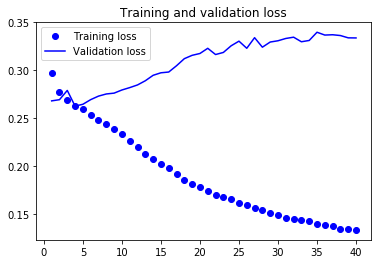

In [19]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()